In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   modena
   2   roma
   3   vicenza
   4   gorizia
   5   genova
   6   ancona
   7   salerno
   8   bari
   9   lecco
   10   firenze
   11   brescia
   12   pisa
   13   bergamo
   14   sassari
   15   caserta
   16   brindisi
   17   alessandria
   18   vercelli
   19   terni
   20   torino
   21   messina
   22   campobasso
   23   matera
   24   ragusa
   25   cosenza
   26   agrigento
   27   cagliari
   28   savona
   29   potenza
   30   grosseto
   31   l_aquila
   32   trento
   33   frosinone
   34   bologna
   35   taranto
   36   isernia
   37   udine
   38   parma
   39   rovigo
   40   crotone
   41   rimini
   42   catanzaro
   43   varese
   44   biella
   45   viterbo
   46   palermo
   47   mantova
   48   ascoli_piceno
   49   venezia
   50   padova
   51   massa
   52   cuneo
   53   arezzo
   54   pavia
   55   asti
   56   vibo_valentia
   57   lodi
   58   belluno
   59   sondrio
   6

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 modena
2 roma
3 vicenza
4 gorizia
5 genova
6 ancona
7 salerno
8 bari
9 lecco
10 firenze
11 brescia
12 pisa
13 bergamo
14 sassari
15 caserta
16 brindisi
17 alessandria
18 vercelli
19 terni
20 torino
21 messina
22 campobasso
23 matera
24 ragusa
25 cosenza
26 agrigento
27 cagliari
28 savona
29 potenza
30 grosseto
31 l_aquila
32 trento
33 frosinone
34 bologna
35 taranto
36 udine
37 parma
38 rovigo
39 crotone
40 rimini
41 catanzaro
42 varese
43 biella
44 viterbo
45 palermo
46 mantova
47 ascoli_piceno
48 venezia
49 padova
50 massa
51 cuneo
52 arezzo
53 pavia
54 asti
55 vibo_valentia
56 lodi
57 belluno
58 sondrio
59 perugia
60 lucca
61 bolzano
62 benevento
63 pordenone
64 napoli
65 latina
66 milano
67 treviso
68 bat
69 como
70 pistoia
71 cremona
72 teramo
73 novara
74 siracusa
75 piacenza
76 pesaro
77 macerata
78 imperia
79 trieste
80 pescara
81 reggio_nell_emilia
82 trapani
83 enna
84 la_spezia
85 lecce
86 prato
87 chieti
88 fermo
89 ferrara
90 foggia
91 forli
92 reggio_di_calabria
93 riet

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.36186  0.02334 
    Test set average RMSE:  0.96433  0.09577 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34016
                       R2:  0.94705


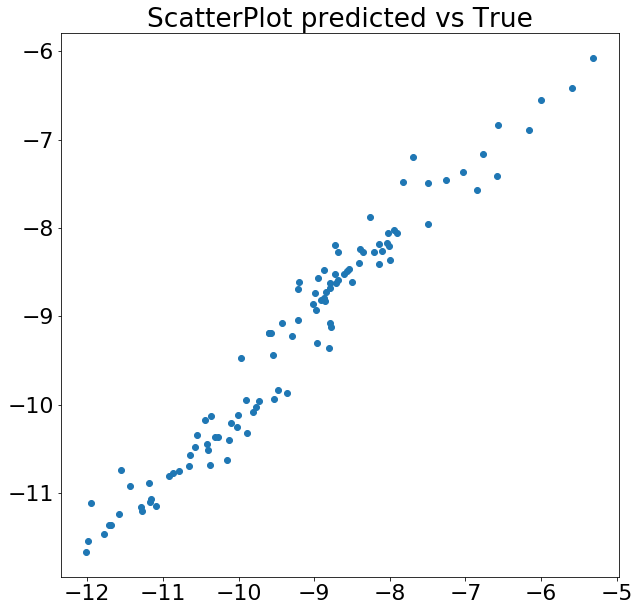

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02491
Feature:               commutersdensity, Score: 0.01630
Feature:                         depriv, Score: 0.02440
Feature:                            lat, Score: 0.64216
Feature:                 Ratio0200ver65, Score: 0.04608
Feature:         avg_wpm10_period1_2020, Score: 0.07775
Feature:           avg_wno_period1_2020, Score: 0.06485
Feature:         avg_wpans_period1_2020, Score: 0.02132
Feature:          avg_wso2_period1_2020, Score: 0.02686
Feature:                  randomfeature, Score: 0.05535


<Figure size 432x288 with 0 Axes>

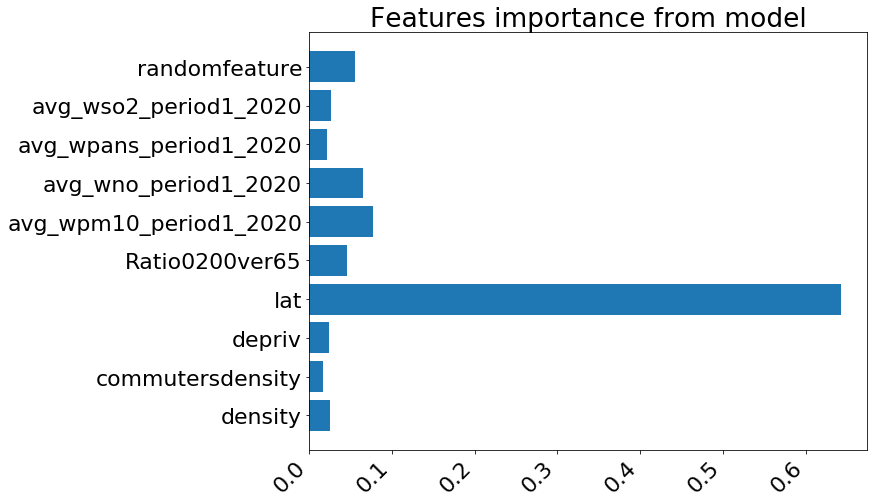

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04452 +/- 0.00416
Feature:               commutersdensity, Score: 0.02492 +/- 0.00327
Feature:                         depriv, Score: 0.04347 +/- 0.00474
Feature:                            lat, Score: 2.86558 +/- 0.37511
Feature:                 Ratio0200ver65, Score: 0.12361 +/- 0.02145
Feature:         avg_wpm10_period1_2020, Score: 0.16062 +/- 0.02540
Feature:           avg_wno_period1_2020, Score: 0.15075 +/- 0.01876
Feature:         avg_wpans_period1_2020, Score: 0.05368 +/- 0.00647
Feature:          avg_wso2_period1_2020, Score: 0.05448 +/- 0.00823
Feature:                  randomfeature, Score: 0.12749 +/- 0.01689


<Figure size 432x288 with 0 Axes>

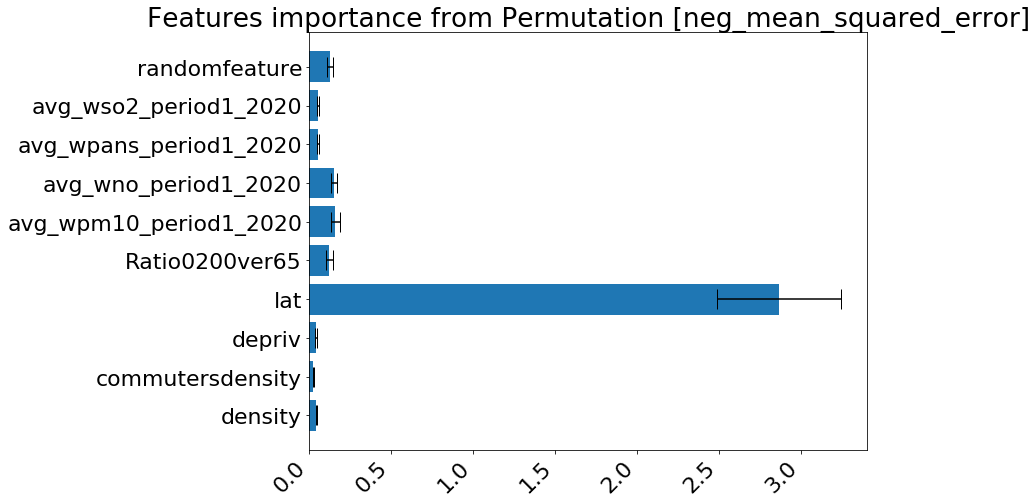

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02037 +/- 0.00191
Feature:               commutersdensity, Score: 0.01140 +/- 0.00150
Feature:                         depriv, Score: 0.01989 +/- 0.00217
Feature:                            lat, Score: 1.31133 +/- 0.17165
Feature:                 Ratio0200ver65, Score: 0.05657 +/- 0.00982
Feature:         avg_wpm10_period1_2020, Score: 0.07350 +/- 0.01163
Feature:           avg_wno_period1_2020, Score: 0.06899 +/- 0.00859
Feature:         avg_wpans_period1_2020, Score: 0.02457 +/- 0.00296
Feature:          avg_wso2_period1_2020, Score: 0.02493 +/- 0.00377
Feature:                  randomfeature, Score: 0.05834 +/- 0.00773


<Figure size 432x288 with 0 Axes>

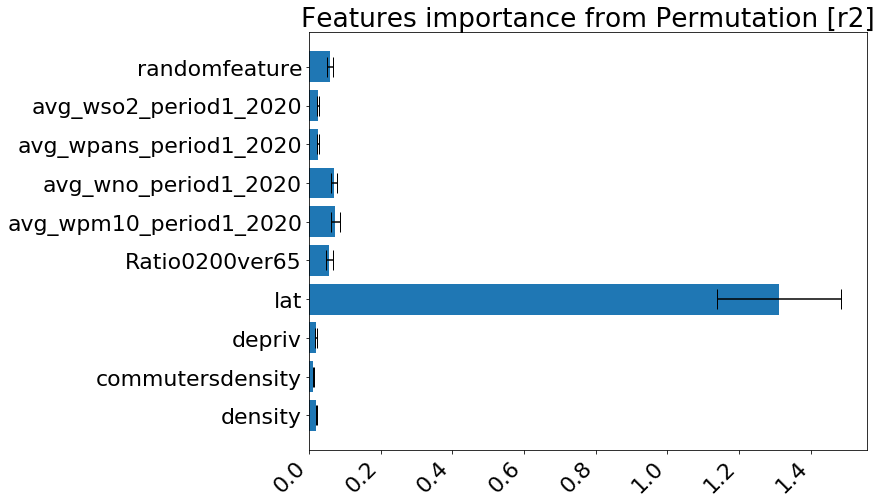

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.00611 +/- 0.01545
Feature:               commutersdensity, Score: 0.01112 +/- 0.00845
Feature:                         depriv, Score: -0.00003 +/- 0.01468
Feature:                            lat, Score: 1.87156 +/- 0.61279
Feature:                 Ratio0200ver65, Score: 0.05013 +/- 0.04142
Feature:         avg_wpm10_period1_2020, Score: 0.00351 +/- 0.11176
Feature:           avg_wno_period1_2020, Score: -0.01150 +/- 0.06158
Feature:         avg_wpans_period1_2020, Score: 0.01426 +/- 0.01569
Feature:          avg_wso2_period1_2020, Score: 0.05365 +/- 0.01650
Feature:                  randomfeature, Score: 0.01050 +/- 0.03180


<Figure size 432x288 with 0 Axes>

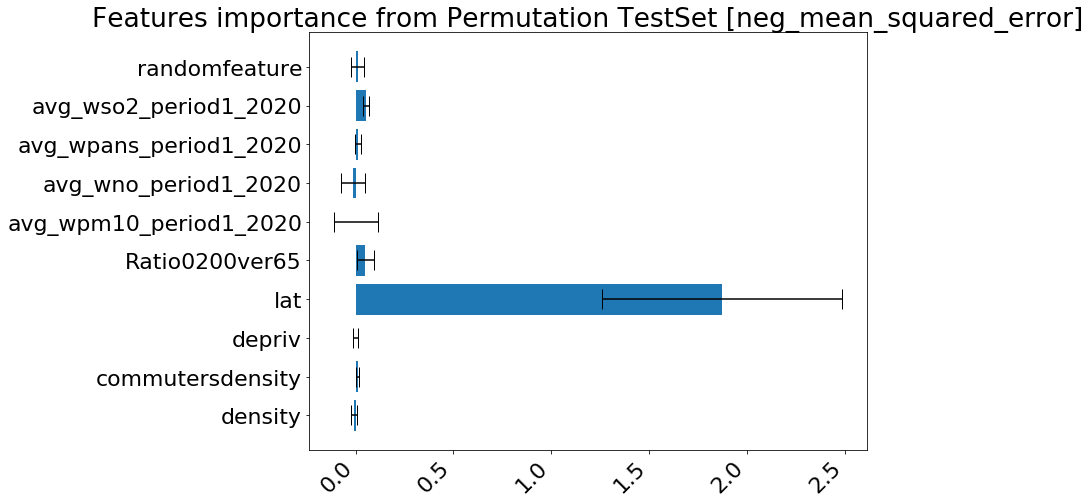

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00338 +/- 0.00853
Feature:               commutersdensity, Score: 0.00614 +/- 0.00467
Feature:                         depriv, Score: -0.00002 +/- 0.00811
Feature:                            lat, Score: 1.03363 +/- 0.33843
Feature:                 Ratio0200ver65, Score: 0.02769 +/- 0.02287
Feature:         avg_wpm10_period1_2020, Score: 0.00194 +/- 0.06172
Feature:           avg_wno_period1_2020, Score: -0.00635 +/- 0.03401
Feature:         avg_wpans_period1_2020, Score: 0.00787 +/- 0.00866
Feature:          avg_wso2_period1_2020, Score: 0.02963 +/- 0.00911
Feature:                  randomfeature, Score: 0.00580 +/- 0.01756


<Figure size 432x288 with 0 Axes>

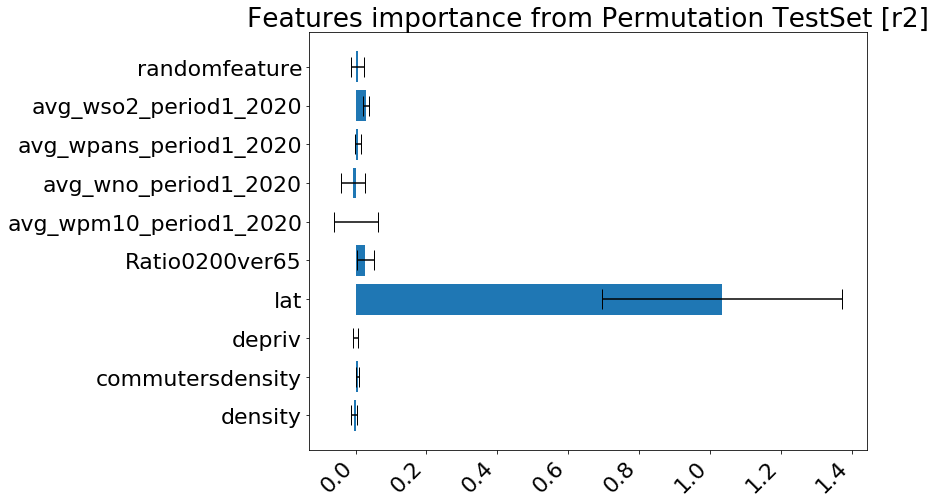

<Figure size 720x720 with 0 Axes>

((0.3618643516814298, 0.02334120505656926),
 (0.9643283727305955, 0.09576507208027799),
 0.34016416730558835,
 {'density': 0.01220107958365931,
  'commutersdensity': 0.006828448054607337,
  'depriv': 0.011913633083543653,
  'lat': 0.7852772615350565,
  'Ratio0200ver65': 0.033874813465270874,
  'avg_wpm10_period1_2020': 0.044015434760671705,
  'avg_wno_period1_2020': 0.041311257568988534,
  'avg_wpans_period1_2020': 0.01471093621903659,
  'avg_wso2_period1_2020': 0.014929368974042874,
  'randomfeature': 0.03493776675512267},
 {'density': 0.012201079583659324,
  'commutersdensity': 0.006828448054607352,
  'depriv': 0.011913633083543661,
  'lat': 0.7852772615350566,
  'Ratio0200ver65': 0.03387481346527089,
  'avg_wpm10_period1_2020': 0.044015434760671705,
  'avg_wno_period1_2020': 0.04131125756898853,
  'avg_wpans_period1_2020': 0.014710936219036602,
  'avg_wso2_period1_2020': 0.014929368974042881,
  'randomfeature': 0.03493776675512267},
 {'density': -0.003060675054123002,
  'commutersde

In [6]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures", showplot=True)

In [7]:
# here we test grid opt to get a model not overfitting 

importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)

1  of  1200 Train RMSE:  0.3872946191085747
1  of  1200  Test RMSE:  0.9214301192757178
2  of  1200 Train RMSE:  0.36317487550951805
2  of  1200  Test RMSE:  0.9870718706684783
3  of  1200 Train RMSE:  0.4527770293106464
3  of  1200  Test RMSE:  0.9585191805829956
4  of  1200 Train RMSE:  0.4908819646835301
4  of  1200  Test RMSE:  0.9961230682062655
5  of  1200 Train RMSE:  0.6875755720086242
5  of  1200  Test RMSE:  0.9701084098089726
6  of  1200 Train RMSE:  0.7360771860034324
6  of  1200  Test RMSE:  1.003661919417812
7  of  1200 Train RMSE:  0.7892699719295609
7  of  1200  Test RMSE:  0.9842513015684219
8  of  1200 Train RMSE:  0.8439561606024674
8  of  1200  Test RMSE:  1.0950137224133025
9  of  1200 Train RMSE:  0.44807752343801455
9  of  1200  Test RMSE:  0.9258594603925401
10  of  1200 Train RMSE:  0.4592101792800682
10  of  1200  Test RMSE:  0.9743112598865916
11  of  1200 Train RMSE:  0.4824682291533034
11  of  1200  Test RMSE:  0.9600082088169274
12  of  1200 Train RMSE:  0

In [ ]:
import pprint

#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt", showplot=True, optimisedparams=besthyperF)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=besthyperF )

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocommut", pout=sys.stdout, showplot=True)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocommut_opt", showplot=True, optimisedparams=besthyperF)